**извлечение признаков из текста на естественном языке**

классификатор текстов HashingVectorizer

Евгений Борисов borisov.e@solarl.ru

## библиотеки

In [1]:
import re
# import gzip
import numpy as np
import numpy.random as rng
import pandas as pd
from tqdm import tqdm

np.set_printoptions(precision=2) # вывод на печать чисел до 2 знака
pd.options.display.max_colwidth = 200 

tqdm.pandas()

In [2]:
# import numpy as np
# import pandas as pd
# import re

In [3]:
from sklearn import __version__ as SKLEARN_VERSION

from sklearn.feature_extraction.text import HashingVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

SKLEARN_VERSION

'0.24.1'

## тексты

In [4]:
# загружаем тексты
data = pd.read_pickle('../data/news.pkl.gz')
print('записей:',len(data))
data.sample(5)

записей: 3196


,text,tag
112,"Положение команд после пятого тура Лиги чемпионов В пятом туре группового\nэтапа Лиги чемпионов ""Манчестер юнайтед"" не смог воспользоваться\nпреимуществом своего поля, сыграв вничью 0:0 с испански...",sport
3042,"В филиале ""<object>МРСК Сибири</object>"" - ""Алтайэнерго"" продолжаются работы по масштабной реконструкции высоковольтной линии 110 кВ ""Петропавловское Солонешное"". Подробности сегодня, 16 июля, со...",social
2122,"Полузащитник «Краснодара» и сборной России Павел Мамаев ответил экс-наставнику «быков» Олегу Кононову, который ранее заявил, что игрок не сделал определенных выводов после скандала, связанного с в...",sport
2618,"В прошлом году социологи и лауреат Нобелевской премии Ангус Дитон заявили, что Америку поразила эпидемия «бытовой наркомании». Обезболивающие и безобидные лекарства не только не помогают, но еще и...",science
2423,"Трагикомедия Демьяна Шазела ""Ла-Ла Ленд"" признана лучшим фильмом этого года. Critic`s Choice присуждается ежегодно и считается своеобразной подготовкой к церемонии вручения премии американской кин...",culture


## токенизация и очистка

In [5]:
# собираем словарь из текстов
def get_vocabulary(ds):
    vcb = [ set(s) for s in ds.tolist() ]
    return sorted(set.union(*vcb))

In [6]:
# применяет список замен pat к строке s
def replace_patterns(s,pat):
    if len(pat)<1: return s
    return  replace_patterns( re.sub(pat[0][0],pat[0][1],s), pat[1:] )

# нормализация текста
def string_normalizer(s):
    pat = [
       [r'ё','е'] # замена ё для унификации
       ,[r'</?[a-z]+>',' '] # удаляем xml
       ,[r'[^a-zа-я\- ]+',' '] # оставляем только буквы, пробел и -
       ,[r' -\w+',' '] # удаляем '-й','-тый' и т.п.
       ,[r'\w+- ',' ']
       ,[r' +',' '] # удаляем повторы пробелов
    ]
    return replace_patterns(s.lower(),pat).strip()

# разрезаем стоки на слова
def tokenize(s): return [ w for w in s.split(' ') if (len(w)>1) ]

In [7]:
data['ctext'] = data['text'].progress_apply(string_normalizer)

100%|██████████| 3196/3196 [00:00<00:00, 5194.61it/s]


In [8]:
vcb =  get_vocabulary( data['ctext'].progress_apply( tokenize ) )
print('словарь %i слов'%(len(vcb)))
# pd.DataFrame( vcb ).to_csv('voc.txt',index=False,header=False)

100%|██████████| 3196/3196 [00:00<00:00, 26479.16it/s]


словарь 83094 слов


In [9]:
data.sample(5)

,text,tag,ctext
802,"С электропилой и долотом. Белорусы создадут на Колыме ледяную вышиванку\n\n6 декабря 2016 в 11:50\n\nДенис Мартинович / TUT.BY\n\nБелорусские скульпторы летят на Колыму, чтобы принять участие в де...",culture,с электропилой и долотом белорусы создадут на колыме ледяную вышиванку декабря в денис мартинович tut by белорусские скульпторы летят на колыму чтобы принять участие в десятом международном конкур...
2127,"Бывший главный тренер «Краснодара» Олег Кононов рассказал о своем отношении к полузащитнику «быков» Павлу Мамаева, после того как был замечен на вечеринке в Монте-Карло.\n\n\n\n\n\n— Когда это все...",sport,бывший главный тренер краснодара олег кононов рассказал о своем отношении к полузащитнику быков павлу мамаева после того как был замечен на вечеринке в монте-карло когда это все произошло я сразу ...
2821,"Корпорация Google представила проект Google Earth Engine в режиме Timelapse, который позволяет узнать, как менялась поверхность Земли за три десятка лет. Соответствующее интересное видео появилось...",tech,корпорация google представила проект google earth engine в режиме timelapse который позволяет узнать как менялась поверхность земли за три десятка лет соответствующее интересное видео появилось в ...
1958,"Об этом говорится в выпуске британской деловой газеты во вторник, 13 декабря. Financial Times считает, что миллиардер переписал правила политики своей страны.\n\nТеперь президент, являющийся специ...",politics,об этом говорится в выпуске британской деловой газеты во вторник декабря financial times считает что миллиардер переписал правила политики своей страны теперь президент являющийся специалистом по ...
2891,"Мы уже имели удовольствие лицезреть новый седан Kia с купеобразным силуэтом на шпионских снимках, но, оказывается, стильная машина полна сюрпризов.\n\nКомпания Kia представила второе интригующее в...",auto,мы уже имели удовольствие лицезреть новый седан kia с купеобразным силуэтом на шпионских снимках но оказывается стильная машина полна сюрпризов компания kia представила второе интригующее видео с ...


## Vectorizer

In [10]:
def tokenizer(s): 
    for w in s.split(' '):
        if (len(w)>1): 
            yield w

tf = HashingVectorizer( n_features=4096, norm='l2', tokenizer=tokenizer,token_pattern=None).fit( data['ctext'] )

## формируем датасеты

In [11]:
X = tf.transform( data['ctext'] )
X.shape

(3196, 4096)

In [12]:
labels = { t:i for i,t in enumerate(sorted(set(data['tag']))) }
labels

{'auto': 0,
 'culture': 1,
 'economics': 2,
 'health': 3,
 'incident': 4,
 'politics': 5,
 'realty': 6,
 'reclama': 7,
 'science': 8,
 'social': 9,
 'sport': 10,
 'tech': 11,
 'woman': 12}

In [13]:
y = data['tag'].map(labels).values
y

array([5, 1, 1, ..., 8, 5, 9])

In [14]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=326 )
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2237, 4096), (2237,), (959, 4096), (959,))

## обучаем классификатор

In [15]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(loss='hinge',max_iter=1000, tol=0.19)
clf.fit(X_train,y_train)

SGDClassifier(tol=0.19)

## тестируем

In [16]:
o = clf.predict(X_train)
accuracy_score(y_train,o)

0.9995529727313366

In [17]:
o = clf.predict(X_test)
accuracy_score(y_test,o)

0.8206465067778936

In [18]:
print( classification_report(y_test,o) )

              precision    recall  f1-score   support

           0       0.96      0.87      0.92        87
           1       0.73      0.82      0.77       101
           2       0.78      0.79      0.78        76
           3       0.73      0.52      0.60        31
           4       0.85      0.93      0.89       123
           5       0.80      0.92      0.85       177
           6       0.82      0.43      0.56        21
           7       1.00      0.59      0.74        17
           8       0.87      0.99      0.92        68
           9       0.50      0.34      0.41        44
          10       0.96      0.93      0.95       118
          11       0.72      0.67      0.70        89
          12       1.00      0.71      0.83         7

    accuracy                           0.82       959
   macro avg       0.82      0.73      0.76       959
weighted avg       0.82      0.82      0.81       959



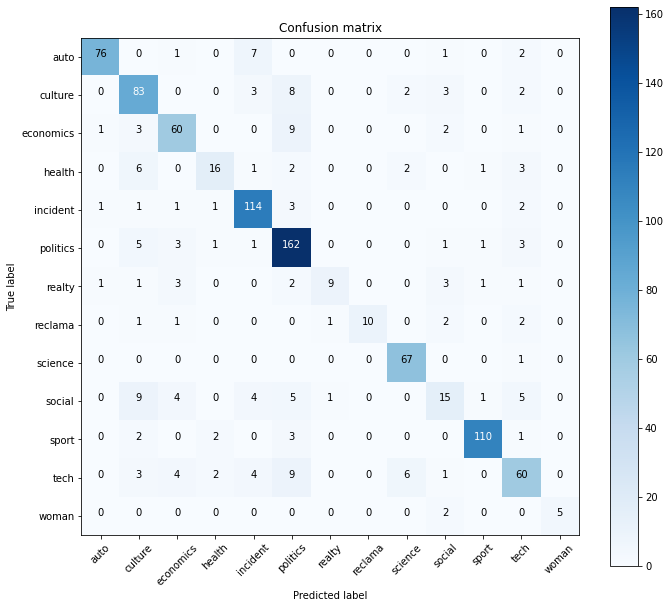

In [19]:
from matplotlib import pyplot as plt
import itertools

classes = sorted(labels.keys())
cm = confusion_matrix(y_test,o)
tick_marks = np.arange(len(classes))

plt.figure(figsize=(10,9))

plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.title('Confusion matrix')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()

plt.show()

---

In [20]:
o = clf.predict(X)

labels_inv = { labels[k]:k for k in labels }

for n in range(10):
    i = rng.randint(len(data))
    print('tag:',data.iloc[i,1])
    print('predict:',labels_inv[o[i]])
    print(re.sub(r'\n\s*\n',' ',data.iloc[i,0][:200])+'...')
    print('- - - - - - - - - - - - - - - - - -')
    

tag: science
predict: science
10:21 - 13.12.2016 Американской компании потребуется больше времени для оценки систем запуска ракеты. Компания Илона Маска SpaceX перенесла запуск пилотируемых капсул к Международной космической ста...
- - - - - - - - - - - - - - - - - -
tag: science
predict: science
Сегодня жители Земли увидят последнее суперлуние в этом году Ранее данное явление можно было наблюдать в октябре и ноябре В ночь на 14 декабря полнолуние примерно совпадёт по времени с максимальным ...
- - - - - - - - - - - - - - - - - -
tag: incident
predict: incident
На востоке Москвы горит склад пиломатериалов. Он расположен в одноэтажном деревянном здании на Мироновской улице, дом 32. На место ЧП прибыли пожарно-спасательные расчеты. Они уже приступили к ликвида...
- - - - - - - - - - - - - - - - - -
tag: auto
predict: auto
Японская компания Mitsubishi вывела на дорожные тесты свой новый компактвэн повышенной проходимости. Предсерийный прототип модели, предназначенной для рынка Индонезии, 